In [1]:
# note: fdfdpy and nonlinear_avm must be in PATH
import sys
sys.path.append('..')
from fdfdpy.simulation import Simulation
from optimization import Optimization
from structures import three_port

import numpy as np
import matplotlib.pylab as plt
import scipy.sparse as sp

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
lambda0 = 2e-6
c0 = 3e8
omega = 2*np.pi*c0/lambda0  # angular frequency (2pi)
dl = 0.4e-1                   # grid size (L0)
Nx = 200
Ny = 1
shape = (Nx,Ny)           # shape of domain (in grids)
NPML = [15, 15]             # number of pml grid points on x and y borders
pol = 'Ez'                  # polarization (either 'Hz' or 'Ez')

In [5]:
# define the two port parameters
L = 4
H = 4
w = .2
d = 2
# d = int(d/2/dl)*dl*2
eps_m = 5
spc = 1
l = 2

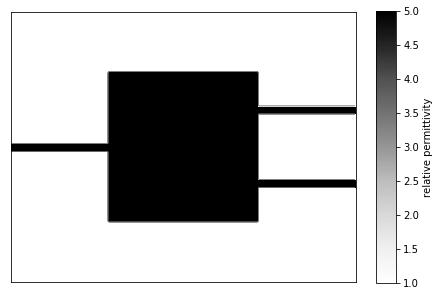

(230, 180)


In [7]:
# define permittivity of three port system
eps_r = three_port(L, H, w, d, dl, l, spc, NPML, eps_start=5)
shape = (Nx,Ny) = eps_r.shape
nx, ny = int(Nx/2), int(Ny/2)
simulation = Simulation(omega,eps_r,dl,NPML,pol)
simulation.plt_eps()
plt.show()
print(eps_r.shape)

In [11]:
chi3 = 2.8*1e-18                           # Silcion in m^2/V^2 from Boyd's book
nl_region = np.array(eps_r > 1).astype(int)
nl_region[:nx-int(L/2/dl),:] = 0
nl_region[nx+int(L/2/dl):,:] = 0

# simulation to solve
simulation = Simulation(omega, eps_r, dl, NPML, 'Ez')
simulation.add_mode(3.5, 'x', [30, ny], int(d/dl), scale=70)
simulation.setup_modes()
print('input power of {} W/L0'.format(simulation.W_in))
# top modal profile (kind of a hack, could be nice to get this without making a simulation())
top = Simulation(omega, eps_r, dl, NPML, 'Ez')
top.add_mode(3.5, 'x', [Nx-30, ny+int(d/2/dl)], int(d/dl))
top.setup_modes()
J_top = np.abs(top.src)  # sometimes negative and sometimes positive. So I just abs it for consistency

# bottom modal profile
bot = Simulation(omega, eps_r, dl, NPML, 'Ez')
bot.add_mode(3.5, 'x', [Nx-30, ny-int(d/2/dl)], int(d/dl))
bot.setup_modes()
J_bot = np.abs(bot.src)

input power of 10.097486807513818 W/L0


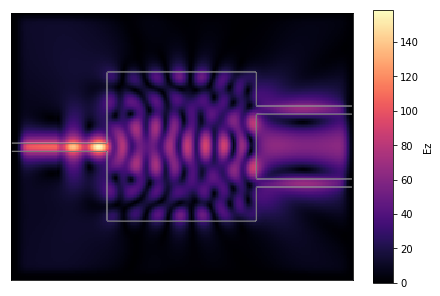

In [12]:
# plot linear field
(Hx,Hy,Ez) = simulation.solve_fields()
simulation.plt_abs(outline=True, cbar=True);

In [14]:
design_region = nl_region

# Re-initialize the simulation
simulation = Simulation(omega, eps_r, dl, NPML, 'Ez')
simulation.add_mode(3.5, 'x', [30, ny], int(d/dl), scale=70)
simulation.setup_modes()
simulation.nonlinearity = []
simulation.add_nl(chi3, design_region)

# define linear and nonlinear parts of objective function + the total objective function form
J = {}
J['linear']    = lambda e, eps_r: np.sum(np.square(np.abs(e))*J_top)
J['nonlinear'] = lambda e, eps_r: np.sum(np.square(np.abs(e))*J_bot)
J['total']     = lambda J_lin, J_nonlin: J_lin + J_nonlin

# define the derivatives
dJ = {}
dJ['dE_linear']    = lambda e, eps_r: np.conj(e)*J_top
dJ['dE_nonlinear'] = lambda e, eps_r: np.conj(e)*J_bot
dJ['total'] = lambda J_lin, J_nonlin, dJ_lin, dJ_nonlin: dJ_lin + dJ_nonlin

In [15]:
# initialize an optimization object with the optimization-specific parameters
opt_both = Optimization(Nsteps=100, J=J, dJ=dJ, eps_max=eps_m, step_size=.1, solver='newton', opt_method='adam')
(avm_grads, num_grads) = opt_both.check_deriv_lin(simulation, design_region)
for i in range(len(avm_grads)):
    print(avm_grads[i], num_grads[i], np.abs((avm_grads[i] - num_grads[i])/avm_grads[i]))

(avm_grads, num_grads) = opt_both.check_deriv_nonlin(simulation, design_region)
for i in range(len(avm_grads)):
    print(avm_grads[i], num_grads[i], np.abs((avm_grads[i] - num_grads[i])/avm_grads[i]))

-3.448101738588382 -3.4481071816117037 1.5785564738198948e-06
-7.6380146001673195 -7.638028382643824 1.8044579941837785e-06
-0.38710039861964307 -0.3871037915814668 8.765069309723403e-06
7.575500006626969 7.5755036232294515 4.774077591205353e-07
1.0916682447130743 1.0916674727923237 7.07101955554085e-07
22.302546955336016 22.30256346592796 7.403007368333883e-07
15.69860529579961 15.698613642598502 5.316904741325979e-07
0.5239558337576311 0.5239562779024709 8.476761039378137e-07
-0.1229787091117013 -0.12297909051994793 3.101416898743508e-06
-6.236942895896035 -6.236950666789198 1.245945857341422e-06


100% (100 of 100) |######################| Elapsed Time: 0:05:37 ETA:  00:00:00

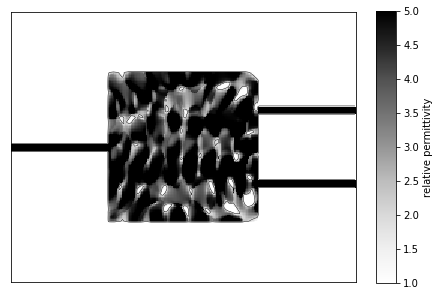

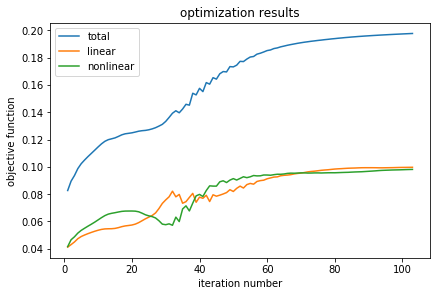

In [18]:
# run that optimization with the simulation and your objective function stuff
(new_eps_1) = opt_both.run(simulation, design_region)
simulation.plt_eps()
plt.show()
opt_both.plt_objs(scaled='E2_in')
plt.show()

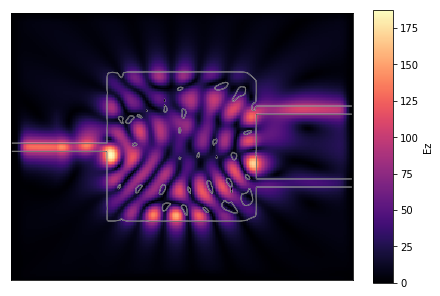

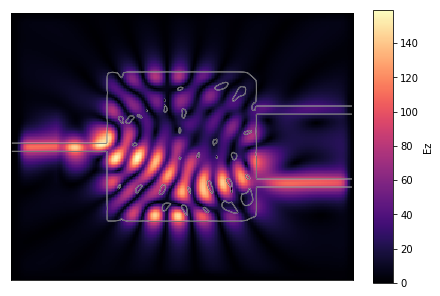

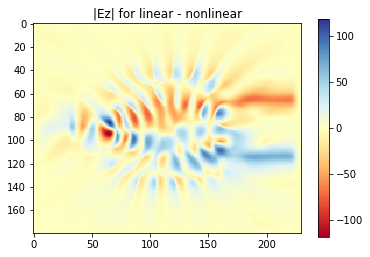

In [20]:
# compare the nonlinear and linear fields
(Hx,Hy,Ez) = simulation.solve_fields()
simulation.plt_abs()
plt.show()

(Hx_nl,Hy_nl,Ez_nl,_) = simulation.solve_fields_nl()
simulation.plt_abs()
plt.show()

difference = np.abs(Ez).T - np.abs(Ez_nl).T
plt.imshow(difference, vmin=-np.max(difference), vmax=np.max(difference), cmap='RdYlBu')
plt.colorbar()
plt.title('|Ez| for linear - nonlinear')
plt.show()

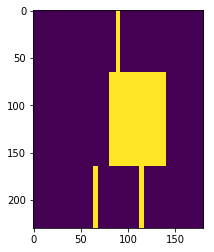

In [26]:
eps_r = three_port(L, H, w, d, dl, l, spc, NPML, eps_start=5)
eps_r[nx-50:nx+50,1:80] = 1
plt.imshow(eps_r)
plt.show()

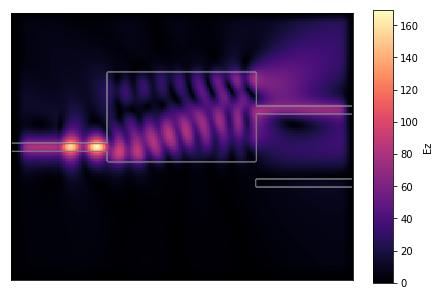

In [27]:
simulation.eps_r = eps_r
# plot linear field
(Hx,Hy,Ez) = simulation.solve_fields()
simulation.plt_abs(outline=True, cbar=True);

 92% (185 of 200) |####################  | Elapsed Time: 0:10:06 ETA:   0:01:11

the simulation did not converge, reached 0.2731979811004937


 93% (186 of 200) |####################  | Elapsed Time: 0:10:23 ETA:   0:03:47

the simulation did not converge, reached 0.13599932714470023


 95% (191 of 200) |##################### | Elapsed Time: 0:11:01 ETA:   0:00:50

the simulation did not converge, reached 0.9465683995244674


 96% (192 of 200) |##################### | Elapsed Time: 0:11:18 ETA:   0:02:09

the simulation did not converge, reached 0.4931679636142002


 96% (193 of 200) |##################### | Elapsed Time: 0:11:35 ETA:   0:02:01

the simulation did not converge, reached 0.11138335475133337


 97% (194 of 200) |##################### | Elapsed Time: 0:11:51 ETA:   0:01:36

the simulation did not converge, reached 0.6994323650005522


 97% (195 of 200) |##################### | Elapsed Time: 0:12:07 ETA:   0:01:20

the simulation did not converge, reached 0.4450351154602593


 98% (197 of 200) |##################### | Elapsed Time: 0:12:28 ETA:   0:00:16

the simulation did not converge, reached 0.09181053418696564


100% (200 of 200) |######################| Elapsed Time: 0:12:54 ETA:  00:00:00

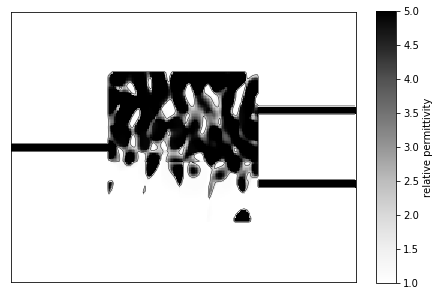

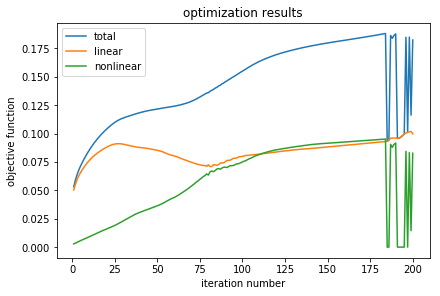

In [30]:
# Re-initialize the simulation
simulation = Simulation(omega, eps_r, dl, NPML, 'Ez')
simulation.add_mode(3.5, 'x', [30, ny], int(d/dl), scale=70)
simulation.setup_modes()
simulation.nonlinearity = []
simulation.add_nl(chi3, design_region)

# run that optimization with the simulation and your objective function stuff
opt_both = Optimization(Nsteps=200, J=J, dJ=dJ, eps_max=eps_m, step_size=.05, solver='newton', opt_method='adam')
(new_eps_2) = opt_both.run(simulation, design_region)
simulation.plt_eps()
plt.show()
opt_both.plt_objs(scaled='E2_in')
plt.show()